In [1]:
import sys
sys.version

'3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) \n[GCC 7.3.0]'

In [2]:
import pyspark
from pyspark import SparkContext, SparkConf
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

conf = SparkConf().setMaster("local").setAppName("K_means")
sc = SparkContext(conf=conf).getOrCreate()

# 讀取資料

In [3]:
def readCentroids(_input):
    with open(_input) as fp:
        c1 = fp.readlines()

    for i in range(len(c1)):
        c1[i] = c1[i].strip().split()
    for i in range(len(c1)):
        for j in range(len(c1[i])):
            c1[i][j] = float(c1[i][j])
    k ,dim = len(c1), len(c1[0])
    return c1, k, dim


In [4]:
def readData(_input):
    with open(_input) as fp:
        data = fp.readlines()

    for i in range(len(data)):
        data[i] = data[i].strip().split()

    for i in range(len(data)):
        for j in range(len(data[i])):
            data[i][j] = float(data[i][j])

    for i in range(len(data)):
        data[i] = tuple(data[i])
    
    return data

# 兩種計算distance的方式

In [5]:
def Euclidean_dis_list(a ,b):
    Euc_dis_square = sum([math.pow(a_ - b_, 2) for a_, b_ in zip(a, b)])    
    return math.sqrt(Euc_dis_square)

In [6]:
def Manhattan_dis_list(a ,b):
    return sum([abs(a_ - b_) for a_, b_ in zip(a, b)])

In [7]:
def add(a ,b):
    return [a_ + b_ for a_, b_ in zip(a, b)]

# 兩種distance的mpper function

In [8]:
def get_Euc_dis(_input):
    global centroids, k
    return_list = []
    
    for j in range(k):
        dis = Euclidean_dis_list(_input, centroids[j])
        return_list.append(dis)
    return (_input, return_list)

In [9]:
def get_Man_dis(_input):
    global centroids, k
    return_list = []
    
    for j in range(k):
        dis = Manhattan_dis_list(_input, centroids[j])
        return_list.append(dis)
    return (_input, return_list)

# 更新centroid的mapper function

In [10]:
def cal_new_centroid(_input):
    group_id = _input[0]
    group_sum = _input[1][0]
    group_len = len(_input[1][1])
    centroid = [sum_ / group_len for sum_ in group_sum]
    return (group_id, centroid)

# 針對每個cluster, 分別計算它們的cost

In [11]:
def cal_total_Euc_cost(_input):
    centroid = _input[1][0]
    cluster_list = _input[1][1]
    cost = 0
    for cluster in cluster_list:
        cost += Euclidean_dis_list(centroid, cluster)
    return (_input[0], cost)

In [12]:
def cal_total_Man_cost(_input):
    centroid = _input[1][0]
    cluster_list = _input[1][1]
    cost = 0
    for cluster in cluster_list:
        cost += Manhattan_dis_list(centroid, cluster)
    return (_input[0], cost)

# 用Euclidean來計算Kmeans
## step1: 先針對每個點進行cluster的分配
## step2: 計算centroids
## step3: update centroids

In [13]:
def Euclidean(data, iters):
    global centroids
    data = sc.parallelize(data)
    cost_history = []
    centroids_history = []
    group_history = []
    for i in range(MAX_ITERS):
        # step1
        dis = data.map(get_Euc_dis) # get each point to each centriod distance (point, [point to each centriod distance])
        dis_idx = dis.map(lambda s: (s[0], s[1].index(min(s[1])))) # get the idx of min distance (point, min centriod idx)
        cluster_group = dis_idx.map(lambda s: (s[1], s[0])).groupByKey() # get cluster number (centriod idx, cluster list)
        # step2
        new_centroids_sum = dis_idx.map(lambda s: (s[1], s[0])).reduceByKey(add).join(cluster_group) # (centriod idx,(cluster sum, cluster list))
        new_centroids = new_centroids_sum.map(cal_new_centroid) # get new centriods (centriod idx, centriod position)
        centroids_history.append(new_centroids.collect().copy())
        # calculate cost
        cost = sc.parallelize(enumerate(centroids)).join(cluster_group).map(cal_total_Euc_cost) # calculate cost (centriod idx, (centriod pos, cluster list))
        cost_history.append(cost.collect())
        # step3: update
        for idx, val in new_centroids.collect(): # update centeriods
            centroids[idx] = val
    return cost_history, centroids_history

In [14]:
def get_total_cost(c1_cost_history):
    c1_total_cost_list = []
    for i in range(len(c1_cost_history)):
        total_cost = 0
        for j in range(len(c1_cost_history[i])):
            k, value = c1_cost_history[i][j]
            total_cost += value
        c1_total_cost_list.append(total_cost)
    return c1_total_cost_list

In [15]:
def get_Euc_pair(centroids, outputFile):
    res = np.zeros((k, k))
    for i in range(k):
        for j in range(i,k):
            res[i][j] = Euclidean_dis_list(centroids[i], centroids[j])
    res = pd.DataFrame(res)
    res.to_csv(outputFile)
    return res

In [16]:
def get_Man_pair(centroids, outputFile):
    res = np.zeros((k, k))
    for i in range(k):
        for j in range(i,k):
            res[i][j] = Manhattan_dis_list(centroids[i], centroids[j])
    res = pd.DataFrame(res)
    res.to_csv(outputFile)
    return res

# Euclidean

In [17]:
MAX_ITERS = 20
centroids, k ,dim = readCentroids('c1.txt')
data = readData('data.txt')
c1_cost_history, c1_centroids_history = Euclidean(data, MAX_ITERS)

In [18]:
# MAX_ITERS = 20
centroids, k ,dim = readCentroids('c2.txt')
data = readData('data.txt')
c2_cost_history, c2_centroids_history = Euclidean(data, MAX_ITERS)

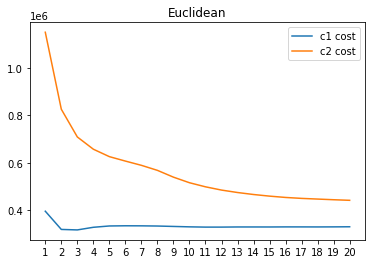

In [19]:
import matplotlib.pyplot as plt
import numpy as np

x_lab = np.arange(1, MAX_ITERS+1)
c1_Euc_cost = get_total_cost(c1_cost_history)
c2_Euc_cost = get_total_cost(c2_cost_history)
plt.title("Euclidean") 
c1 = plt.plot(x_lab, c1_Euc_cost, label = 'c1_cost')
c2 = plt.plot(x_lab, c2_Euc_cost, label = 'c2_cost')

plt.legend(["c1 cost", "c2 cost"])
plt.xticks(x_lab)
plt.savefig("euclidean.png")

In [20]:
print('c1 cost improvement', abs(c1_Euc_cost[19] - c1_Euc_cost[0]) / c1_Euc_cost[0])

c1 cost improvement 0.16569281783988665


In [21]:
print('c2 cost improvement', abs(c2_Euc_cost[19] - c2_Euc_cost[0]) / c2_Euc_cost[0])

c2 cost improvement 0.6160346247542591


In [22]:
last_round_centroids = []
for i in range(k):
    last_round_centroids.append(c1_centroids_history[-1][i][1])
res=get_Euc_pair(last_round_centroids, 'c1_Euc.csv')

In [23]:
last_round_centroids = []
for i in range(k):
    last_round_centroids.append(c2_centroids_history[-1][i][1])
res=get_Euc_pair(last_round_centroids, 'c2_Euc.csv')

In [24]:
last_round_centroids = []
for i in range(k):
    last_round_centroids.append(c1_centroids_history[-1][i][1])
res=get_Man_pair(last_round_centroids, 'c1_EucUpdate_ManCal.csv')

In [25]:
last_round_centroids = []
for i in range(k):
    last_round_centroids.append(c2_centroids_history[-1][i][1])
res=get_Man_pair(last_round_centroids, 'c2_EucUpdate_ManCal.csv')

# Manhattan

In [26]:
def Manhattan(data, iters):
    global centroids
    data = sc.parallelize(data)
    cost_history = []
    centroids_history = []
    group_history = []
    for i in range(MAX_ITERS):
        dis = data.map(get_Man_dis) # get each point to each centriod distance (point, [point to each centriod distance])
        dis_idx = dis.map(lambda s: (s[0], s[1].index(min(s[1])))) # get the idx of min distance (point, min centriod idx)
        cluster_group = dis_idx.map(lambda s: (s[1], s[0])).groupByKey() # get cluster number (centriod idx, cluster list)
        new_centroids_sum = dis_idx.map(lambda s: (s[1], s[0])).reduceByKey(add).join(cluster_group) # (centriod idx,(cluster sum, cluster list))
        new_centroids = new_centroids_sum.map(cal_new_centroid) # get new centriods (centriod idx, centriod position)
        centroids_history.append(new_centroids.collect().copy())
        cost = sc.parallelize(enumerate(centroids)).join(cluster_group).map(cal_total_Man_cost) # calculate cost (centriod idx, (centriod pos, cluster list))
        cost_history.append(cost.collect())

        for idx, val in new_centroids.collect(): # update centeriods
            centroids[idx] = val
    return cost_history, centroids_history

In [27]:
# MAX_ITERS = 20
centroids, k ,dim = readCentroids('c1.txt')
data = readData('data.txt')
c1_cost_history, c1_centroids_history = Manhattan(data, MAX_ITERS)

In [28]:
# MAX_ITERS = 20
centroids, k ,dim = readCentroids('c2.txt')
data = readData('data.txt')
c2_cost_history, c2_centroids_history = Manhattan(data, MAX_ITERS)

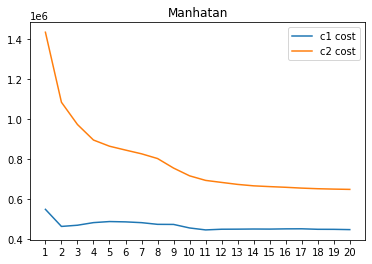

In [29]:
x_lab = np.arange(1, MAX_ITERS+1)
c1_Man_cost = get_total_cost(c1_cost_history)
c2_Man_cost = get_total_cost(c2_cost_history)
plt.title("Manhatan") 
c1 = plt.plot(x_lab, c1_Man_cost, label = 'c1_cost')
c2 = plt.plot(x_lab, c2_Man_cost, label = 'c2_cost')

plt.legend(["c1 cost", "c2 cost"])
plt.xticks(x_lab)
plt.savefig("Manhattan.png")

In [30]:
print('c1 cost improvement', abs(c1_Man_cost[19] - c1_Man_cost[0]) / c1_Man_cost[0])

c1 cost improvement 0.18378954327236885


In [31]:
print('c2 cost improvement', abs(c2_Man_cost[19] - c2_Man_cost[0]) / c2_Man_cost[0])

c2 cost improvement 0.5468569434813407


In [32]:
last_round_centroids = []
for i in range(k):
    last_round_centroids.append(c1_centroids_history[-1][i][1])
res=get_Euc_pair(last_round_centroids, 'c1_ManUpdate_EucCal.csv')

In [33]:
last_round_centroids = []
for i in range(k):
    last_round_centroids.append(c2_centroids_history[-1][i][1])
res=get_Euc_pair(last_round_centroids, 'c2_ManUpdate_EucCal.csv')

In [34]:
last_round_centroids = []
for i in range(k):
    last_round_centroids.append(c1_centroids_history[-1][i][1])
res=get_Man_pair(last_round_centroids, 'c1_Man.csv')

In [35]:
last_round_centroids = []
for i in range(k):
    last_round_centroids.append(c2_centroids_history[-1][i][1])
res=get_Man_pair(last_round_centroids, 'c2_Man.csv')